# Credit Card Fraud Detection
#### By Shadi Bavar, Matthew Euliano, and Claire Parisi


##### Importing Required Libraries & Dataset

In [1]:
#Importing the libraries
import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,precision_recall_curve,auc,roc_auc_score,roc_curve,recall_score,classification_report, f1_score, accuracy_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [2]:
# Import Data
data = pd.read_csv('creditcard.csv')

# Get samples for each class
fraudsDF = data[data.Class == 1]
normalDF = data[data.Class == 0]

#### Regularize Features & Data Prep

In [3]:
#Scaling amount 
std_scale = StandardScaler()
data['Amount'] = std_scale.fit_transform(data['Amount'].values.reshape(-1, 1))
data['Time'] = std_scale.fit_transform(data['Time'].values.reshape(-1, 1))
# data = data.drop(['Time'], axis=1)

#Split dataset into inputs (x) and labels (y)
x = data.drop(['Class'], axis = 1)
y = data['Class']

#### Break dataset into Training and Testing Sets Representative of the Imbalanced Dataset

In [4]:
#split dataset into training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 0, stratify = y)

#### Undersample the Training Set to Balance the Classes

In [5]:

#find instances of fraud in training set
train_fraud_indices = np.array(y_train[y_train== 1].index)
n_train_fraud = len(train_fraud_indices)
train_nonfraud_indices = np.array(y_train[y_train== 0].index)

#Randomly select number of non-fraud transactions to match the number of fraud transactions
random_indices = np.random.choice(train_nonfraud_indices, n_train_fraud, replace = False)
undersample_indices = np.concatenate([train_fraud_indices, random_indices])

#Resample the training data
x_train_u  = x_train.loc[undersample_indices]
y_train_u = y_train.loc[undersample_indices]

## SVM

### Hyperparameter Selection via Grid Search

In [6]:
def Grid_Search_SVM(parameters, score, x_train, y_train):
    print("# Tuning hyper-parameters for %s" % score)

    clf = GridSearchCV(SVC(probability=True), parameters, scoring="%s_macro" % score,n_jobs=-1)
    clf.fit(x_train, y_train)

    print("Best parameters set found on development set:")
    print(clf.best_params_)

    return clf.best_estimator_

In [7]:
def model_performance(model):
    # Create Confusion Matrix
    prediction = model.predict(x_test)
    cnf_matrix = confusion_matrix(y_test, prediction)
    fruads = y_test[y_test == 1]
    non_fruads = y_test[y_test == 0]

    #Calculate metrics
    pfa = cnf_matrix[0][1]/(len(non_fruads))
    pmd = cnf_matrix[1][0]/(len(fruads))
    trpr = cnf_matrix[1][1]/(len(fruads))

    #Precision and Recall and F1 Score
    recall = recall_score(y_test, prediction)
    precision = precision_score(y_test, prediction)
    f1 = f1_score(y_test, prediction)
    print('Recall:', recall, '\nPrecision:', precision, '\nF1:', f1)

    #Plot confusion matrix
    fig = plt.figure()
    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Normal', 'Fraud'])
    plt.yticks(tick_marks, ['Normal', 'Fraud'])
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.text(0, 0, '{}'.format(cnf_matrix[0,0]), ha='center', va='center', color='white', fontsize=12)
    plt.text(1, 0, '{}'.format(cnf_matrix[0,1]), ha='center', va='center', color='black', fontsize=12)
    plt.text(0, 1, '{}'.format(cnf_matrix[1,0]), ha='center', va='center', color='black', fontsize=12)
    plt.text(1, 1, '{}'.format(cnf_matrix[1,1]), ha='center', va='center', color='black', fontsize=12)
    plt.show()

    y_pred = model.fit(x_train_u, y_train_u).decision_function(x_test)
    # fpr, tpr, thresholds = roc_curve(y_test, y_pred, drop_intermediate=False) #Can just show on 1 roc curve because it ends up being the same in both cases with just different threshold
    # fig = plt.figure()
    # plt.plot(fpr, tpr)
    # plt.plot(pfa,trpr, 'ro', label = "Baseline Model")
    # plt.show()

    return pfa, trpr, y_pred, cnf_matrix

### RBF Kernel

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

Recall: 0.8673469387755102 
Precision: 0.0886339937434828 
F1: 0.1608325449385052


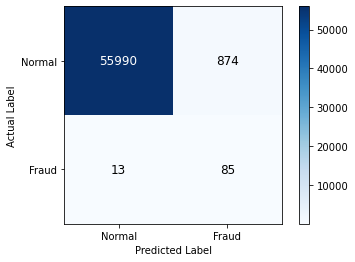

In [8]:
tuning_params_rbf = {"kernel": ["rbf"], "gamma": ['scale', 0.01,1e-3, 1e-4], "C": [1, 10, 100, 1000]}

opt_model_rbf = Grid_Search_SVM(tuning_params_rbf, 'recall', x_train_u, y_train_u)
print()

pfa_rbf, trpr_rbf, y_pred_rbf,cnf_rbf = model_performance(opt_model_rbf)


### Linear Kernel

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}

Recall: 0.8775510204081632 
Precision: 0.06125356125356125 
F1: 0.11451398135818908


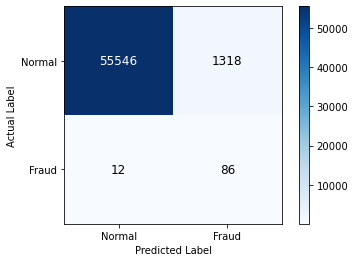

In [9]:
tuning_params_lin = {"kernel": ["linear"], "C": [1, 10, 100, 1000], "class_weight": ['balanced',{0:1, 1:1.25},{0:1, 1:1.5},{0:1, 1:1.75}]}

opt_model_lin = Grid_Search_SVM(tuning_params_lin, 'recall', x_train_u, y_train_u)
print()

pfa_lin, trpr_lin, y_pred_lin, cnf_lin = model_performance(opt_model_lin)

### Polynomial Kernel

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'C': 100, 'degree': 3, 'gamma': 0.01, 'kernel': 'poly'}

Recall: 0.8775510204081632 
Precision: 0.06471030850263355 
F1: 0.12053258584442886


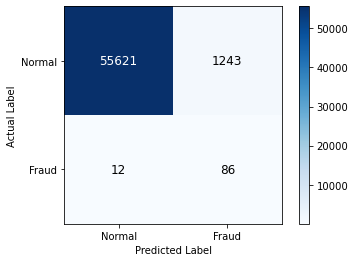

In [10]:
tuning_params_poly = {"kernel": ["poly"], "gamma": ['scale', 0.01,1e-3, 1e-4], "degree":[3,4,5], "C": [1, 10, 100, 1000]}

opt_model_poly = Grid_Search_SVM(tuning_params_poly, 'recall', x_train_u, y_train_u)
print()

pfa_poly, trpr_poly, y_pred_poly, cnf_poly = model_performance(opt_model_poly)

#### Stacked ROC Curves

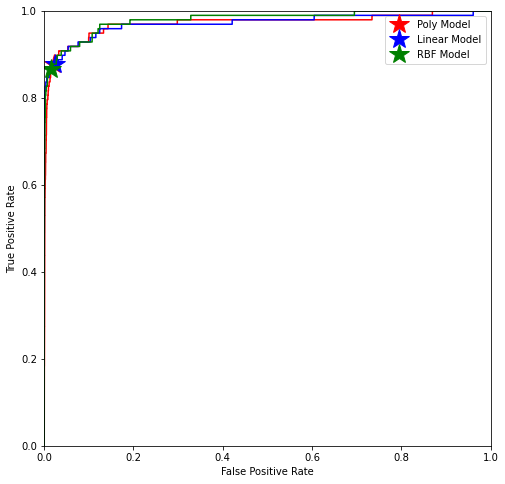

In [11]:

fig = plt.figure(figsize=[8,8])
fpr, tpr, thresholds = roc_curve(y_test, y_pred_poly, drop_intermediate=False)
plt.plot(fpr, tpr, 'r')
plt.plot(pfa_poly,trpr_poly, 'r*', label = "Poly Model",markersize=20)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lin, drop_intermediate=False)
plt.plot(fpr, tpr,'b')
plt.plot(pfa_lin,trpr_lin, 'b*', label = "Linear Model",markersize=20)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_rbf, drop_intermediate=False)
plt.plot(fpr, tpr, 'g')
plt.plot(pfa_rbf,trpr_rbf, 'g*', label = "RBF Model",markersize=20)

plt.axis([0,1,0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()


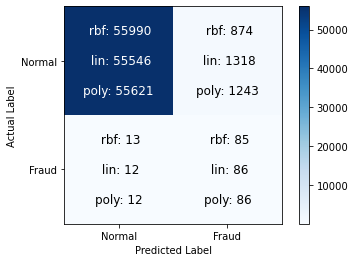

In [14]:
#Plot confusion matrix
fig = plt.figure()
plt.imshow(cnf_rbf, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Normal', 'Fraud'])
plt.yticks(tick_marks, ['Normal', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.text(0, 0, ' rbf: {}\n\n lin: {}\n\npoly: {}'.format(cnf_rbf[0,0],cnf_lin[0,0],cnf_poly[0,0]), ha='center', va='center', color='white', fontsize=12)
plt.text(1, 0, ' rbf: {}\n\n lin: {}\n\npoly: {}'.format(cnf_rbf[0,1],cnf_lin[0,1],cnf_poly[0,1]), ha='center', va='center', color='black', fontsize=12)
plt.text(0, 1, ' rbf: {}\n\n lin: {}\n\npoly: {}'.format(cnf_rbf[1,0],cnf_lin[1,0],cnf_poly[1,0]), ha='center', va='center', color='black', fontsize=12)
plt.text(1, 1, ' rbf: {}\n\n lin: {}\n\npoly: {}'.format(cnf_rbf[1,1],cnf_lin[1,1],cnf_poly[1,1]), ha='center', va='center', color='black', fontsize=12)
plt.show()